In [24]:
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

In [25]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

In [5]:
def generate_spiral(*, num: int, rng: np.random.Generator) -> np.ndarray:
    thetas = rng.uniform(low=0.0, high=6*np.pi, size=(num,))
    rs = thetas * 0.05
    X = np.hstack((
        (rs * np.cos(thetas))[:, None],
        (rs * np.sin(thetas))[:, None],
    ))
    X = X + 0.04 * rng.standard_normal(X.shape) 
    return X

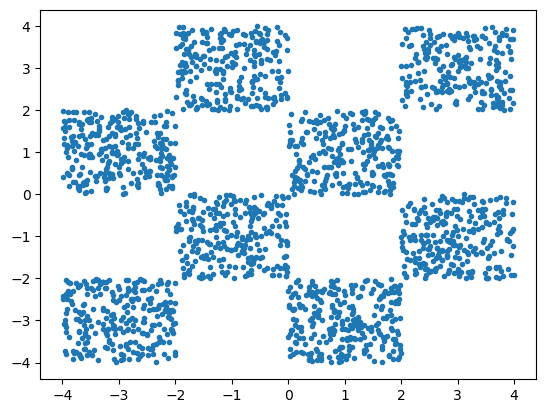

In [11]:
X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

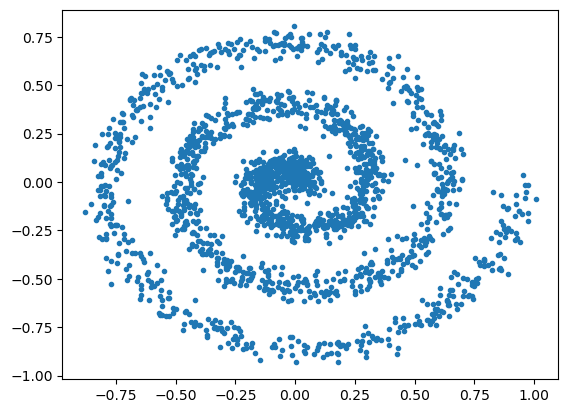

In [26]:
X_train = generate_spiral(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [27]:
Activation = Callable[[jax.Array], jax.Array]

class MLP(nn.Module):
    
    features: Sequence[int]
    activation: Activation = nn.swish

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        x = nn.Dense(self.features[-1])(x)
        return x

model = MLP(features=[64, 64, 2])

print(model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                                 MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,2]  │ float32[1,2]  │                        │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]  │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: float32[2,64]  │
│         │        │               │               │                        │
│         │        │               │               │ 192 (768 B)            │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,64] │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: fl

In [34]:
def dsm_loss(params: chex.ArrayTree, batch: jax.Array, noise_stddev: float, key: chex.PRNGKey) -> float:
    # 使用提供的密钥添加噪声
    noisy_batch = batch + noise_stddev * jax.random.normal(key, batch.shape)
    
    # 预测原始数据
    predictions = model.apply(params, noisy_batch)
    
    # 计算损失：预测与原始数据的 MSE
    loss = jnp.mean((predictions - batch) ** 2)
    return loss



In [39]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))


@jax.jit
def do_batch_update(
    batch: jax.Array,
    params: chex.ArrayTree, 
    opt_state: optax.OptState,
    noise_stddev: float,
    key: chex.PRNGKey
) -> tuple[float, chex.ArrayTree, optax.OptState]:
    loss, grad = jax.value_and_grad(dsm_loss, argnums=1)(params, batch, noise_stddev, key)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [40]:
params = model.init(next(prng_seq), X_train[:1, ...])
opt_state = optimizer.init(params)
bm = BatchManager(data=X_train, batch_size=128, key=next(prng_seq))

noise_stddev = 0.1

losses = []
for _ in tqdm.tqdm(range(5000)):
    batch = next(bm)
    key = next(prng_seq)
    loss, params, opt_state = do_batch_update(batch, params, opt_state, noise_stddev, key)
    losses.append(loss)
losses = np.array(losses)

  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: unsupported operand type(s) for *: 'float' and 'dict'